This is the notebook to build the data processing pipeline to feed into the GRU network. It starts with a slimmed and skimmed csv file with p2_calib being the value to predict, and int_deliv_inv_ub and calib_time being the best values to use. It's important to note that at this point, some of the lumi measurements are taken a bit far from the calibration times. this can be seen by the difference between the lumi-section time and the calib_time values. The best data probably just consistents of the points where these are close.

All data is in its original units.

Also, I'm running this in the Python 3.6.3Kernel

In [1]:
#import the stuff
import pandas as pd #dataframes etc
import matplotlib.pyplot as plt #plotting
import numpy as np
from sklearn import preprocessing
from common.utils import TimeSeriesTensor, create_evaluation_df, mape, scale_shrinker

In [2]:
#load the data
df16 = pd.read_csv('../scripts/slimmed_df_LME38_PNA4_2016.csv')
df17 = pd.read_csv('../scripts/slimmed_df_LME38_PNA4_2017.csv')
df18 = pd.read_csv('../scripts/slimmed_df_LME38_PNA4_2018.csv')
#there are many times when the xtal is not fired upon. This means the laser_datetime is NaN, 
#and importantly, the lumi columns: int_deliv_inv_ub and int_record_inv_ub give an erroneous value.


In [3]:
#the data has multiple possible indices. The most important, is to split the data based on the crystal index which is called Unnamed: 0 at the moment.
df_rename16 = df16.rename(columns={'Unnamed: 0':'xtal_idx', 'Unnamed: 1':'dst_idx'})
xtal_groups = df_rename16.groupby(df_rename16.xtal_idx)
xtal_list = df_rename16.xtal_idx.unique()
#the data has multiple possible indices. The most important, is to split the data based on the crystal index which is called Unnamed: 0 at the moment.
df_rename17 = df17.rename(columns={'Unnamed: 0':'xtal_idx', 'Unnamed: 1':'dst_idx'})
xtal_groups = df_rename17.groupby(df_rename17.xtal_idx)
xtal_list = df_rename17.xtal_idx.unique()
#the data has multiple possible indices. The most important, is to split the data based on the crystal index which is called Unnamed: 0 at the moment.
df_rename18 = df18.rename(columns={'Unnamed: 0':'xtal_idx', 'Unnamed: 1':'dst_idx'})
xtal_groups = df_rename18.groupby(df_rename18.xtal_idx)
xtal_list = df_rename18.xtal_idx.unique()


In [4]:
#chew on it
df_slim16 = df_rename16.groupby('xtal_idx').get_group(54000).dropna(subset=['laser_datetime'])
df_slim16.laser_datetime = pd.to_datetime(df_slim16.laser_datetime)
df_slim16 = df_slim16.set_index('laser_datetime')

#chew on it
df_slim17 = df_rename17.groupby('xtal_idx').get_group(54000).dropna(subset=['laser_datetime'])
df_slim17.laser_datetime = pd.to_datetime(df_slim17.laser_datetime)
df_slim17 = df_slim17.set_index('laser_datetime')
#chew on it
df_slim18 = df_rename18.groupby('xtal_idx').get_group(54000).dropna(subset=['laser_datetime'])
df_slim18.laser_datetime = pd.to_datetime(df_slim18.laser_datetime)
df_slim18 = df_slim18.set_index('laser_datetime')


In [5]:
#stitch lumis
df_slim17.int_deliv_inv_ub = df_slim17.int_deliv_inv_ub + df_slim16.int_deliv_inv_ub[-1]
df_slim18.int_deliv_inv_ub = df_slim18.int_deliv_inv_ub + df_slim17.int_deliv_inv_ub[-1]

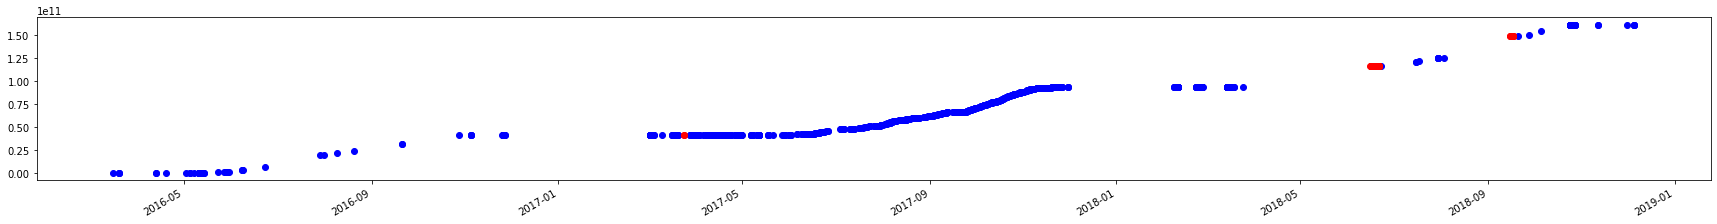

In [6]:
#now we can look at both
fig, ax = plt.subplots(figsize=(30,3))
plt.setp(ax.get_xticklabels(), rotation=30, horizontalalignment='right')
ax.scatter(df_slim16[df_slim16.calibration.isna()].index, df_slim16[df_slim16.calibration.isna()].int_deliv_inv_ub, color='blue')
ax.scatter(df_slim16[df_slim16.calibration < 0.5].index,  df_slim16[df_slim16.calibration < 0.5].int_deliv_inv_ub,  color='red')

ax.scatter(df_slim17[df_slim17.calibration.isna()].index, df_slim17[df_slim17.calibration.isna()].int_deliv_inv_ub, color='blue')
ax.scatter(df_slim17[df_slim17.calibration < 0.5].index,  df_slim17[df_slim17.calibration < 0.5].int_deliv_inv_ub,  color='red')

ax.scatter(df_slim18[df_slim18.calibration.isna()].index, df_slim18[df_slim18.calibration.isna()].int_deliv_inv_ub, color='blue')
ax.scatter(df_slim18[df_slim18.calibration < 0.5].index,  df_slim18[df_slim18.calibration < 0.5].int_deliv_inv_ub,  color='red')

In [7]:
#drop low calibration values
df_slim16 = df_slim16.loc[df_slim16.calibration > 0.5]
df_slim17 = df_slim17.loc[df_slim17.calibration > 0.5]
df_slim18 = df_slim18.loc[df_slim18.calibration > 0.5]

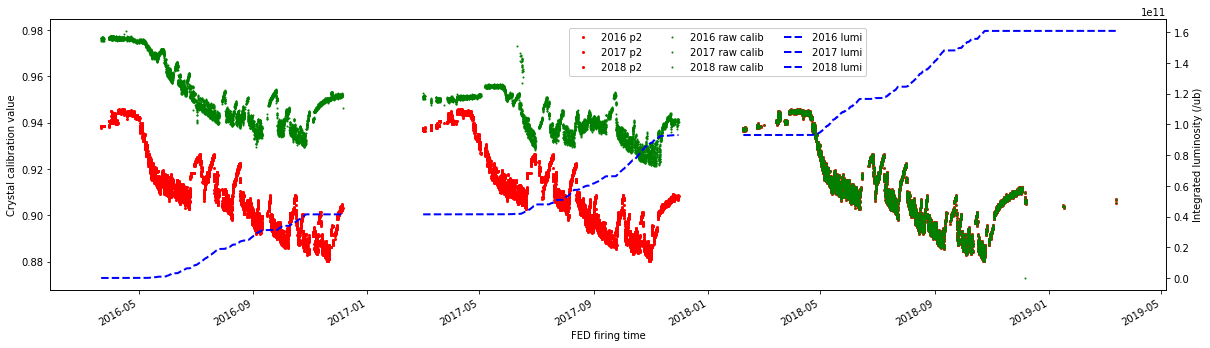

In [8]:
#now lets make a plot of the data
fig, ax1 = plt.subplots(figsize=(20,5))

ax1.set_ylabel('Crystal calibration value')
ax1.set_xlabel('FED firing time')
#ax1.set_ylim([0.87,0.94])
plt.setp(ax1.get_xticklabels(), rotation=30, horizontalalignment='right')

#calibration data
ax1.scatter(df_slim16.index, df_slim16.p2, 
         label='2016 p2', color='red', s=4, linestyle='solid')
ax1.scatter(df_slim17.index, df_slim17.p2, 
         label='2017 p2', color='red', s=4, linestyle='solid')
ax1.scatter(df_slim18.index, df_slim18.p2, 
         label='2018 p2', color='red', s=4, linestyle='solid')

ax1.scatter(df_slim16.index, df_slim16.calibration, 
         label='2016 raw calib', color='green', s=1, linestyle='solid')
ax1.scatter(df_slim17.index, df_slim17.calibration, 
         label='2017 raw calib', color='green', s=1, linestyle='solid')
ax1.scatter(df_slim18.index, df_slim18.calibration, 
         label='2018 raw calib', color='green', s=1, linestyle='solid')




#lumi data on alternate y axis
ax2 = ax1.twinx()
ax2.set_ylabel('Integrated luminosity (/ub)')

ax2.plot(df_slim16.index, df_slim16.int_deliv_inv_ub, 
         label='2016 lumi', color='blue', linewidth=2, linestyle='dashed')
ax2.plot(df_slim17.index, df_slim17.int_deliv_inv_ub, 
         label='2017 lumi', color='blue', linewidth=2, linestyle='dashed')
ax2.plot(df_slim18.index, df_slim18.int_deliv_inv_ub, 
         label='2018 lumi', color='blue', linewidth=2, linestyle='dashed')
#combined legend
fig.legend(ncol=3, loc = (0.47,0.78),framealpha=1)

fig.show()

In [9]:
df_check = pd.read_csv('../data/valid_diff_18_54000.csv')

In [10]:
df_rn = df_check.rename(columns={'Unnamed: 0':'laser_datetime'})
df_rn.laser_datetime = pd.to_datetime(df_rn.laser_datetime)
df_i = df_rn.set_index('laser_datetime')

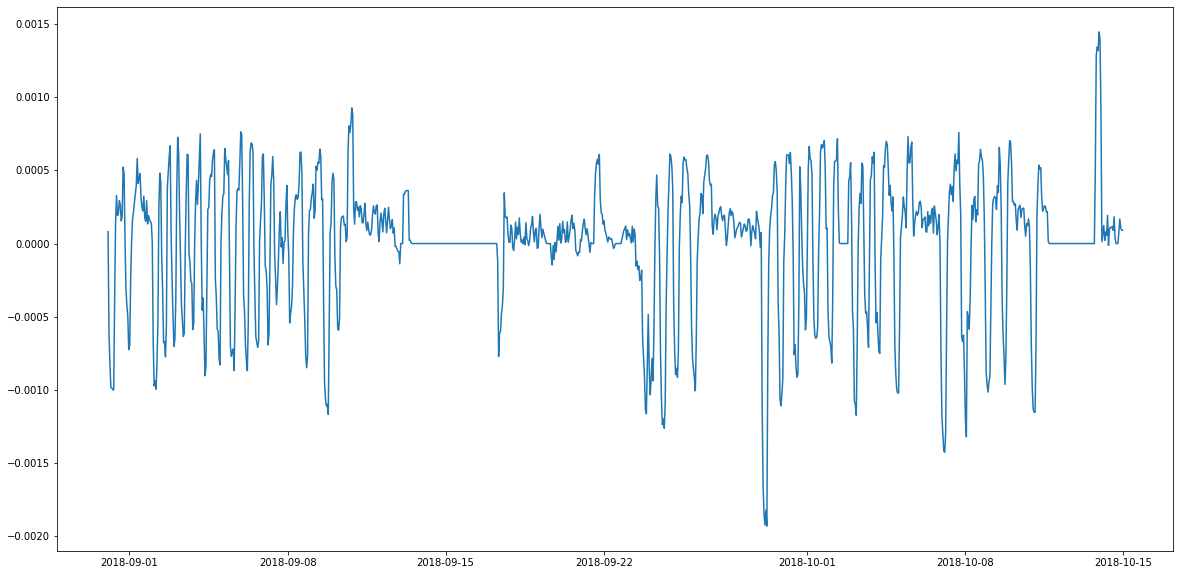

In [11]:
fig, ax = plt.subplots(figsize=(20,10))
ax.plot(df_i.index, df_i.calibration)